# Universidad del Valle de Guatemala
## Facultad de Ingeniería
### Departamento de Computación

---

# Proyecto 2: Análisis Exploratorio
## Proyecto 2. Reto 04: Predicción de compradores recurrentes: cuestionar la línea base - Negocios

**Integrantes:**
- Diego Alexander Hernández Silvestre, 21270
- Linda Inés Jiménez Vides, 21169
- Mario Antonio Guerra Morales, 21008
- David Jonathan Aragon Vasquez, 21053

**Curso:** Data Science  
**Sección:** 10  
**Grupo** 4  

---

Guatemala, 30 de septiembre de 2024


##### 🫳 Para la descarga del dataset de este reto, es necesario la creación de una cuenta dentro de Alibaba Cloud. Para facilitar este proceso se proporcionan los elementos a descargar en estos enlaces:
- Data_Format1: https://drive.google.com/file/d/1jgsaSM0wypPMUWaNlXy5s_kO0uiXNzES/view?usp=sharing
- Data_Format2: https://drive.google.com/file/d/1dnMeaon-ovASN2HEI1WSNfnw-7lyINAh/view?usp=drivesdk
- sample_submission.csv: 

#### 📑 Descripción del dataset

A continuación se describen las variables del dataset utilizadas para el análisis exploratorio:

- `user_id`: Identificador único para el comprador tipo numérica.
- `age_range`: Rango de edad del usuario donde:
    - 1 < 18
    - 2 para el rango [18, 24]
    - 4 para el rango [30, 34]
    - 5 para el rango [35, 39]
    - 6 para el rango [40, 49]
    - 7 y 8 para >= 50
    - 0 y NULL para desconocido
- `gender`: Género del usuario donde:
    - 0 es femenino
    - 1 es masculino
    - 2 y Null para desconocido
- `merchant_id`: Identificador único para el comerciante.

- `label`: Valores entre -1 y 1 donde:
    - 1 indica que `user_id` es un comprador recurrente de `merchant_id`
    - 0 es lo contrario a 1
    - -1 indica que `user_id` no es un nuevo cliente de `merchant_id`
    - Null se encuentra en los datos de prueba indicando que son para predecir.
- `activity_log`: Conjunto de registroos de interacción entre {**user_id**, **merchant_id**}, donde cada registro es una acción representada como ***item_id:category_id:brand_id:time_stamp:action_type***. Los elementos se separan con #
-  `item_id`: Identificador único para el artículo.
- `category_id`: Indentificador único para la categoría a la que pertenece el artículo
- `brand_id` Identificador único para la marca del artículo
- `time_stamp`: Fecha que ocurrió la acción
- `action_type`: Tipo de acción enumerado de 0 a 3 donde:
    - 0 es para clic
    - 1 es para agregar al carrito
    - 2 es para compra
    - 3 es paea agregar a favoritos

In [4]:
import os
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 📩 Inciso 1. Descomprimir los datasets.

In [5]:
def unzipFile(zip_path):
    # Extraer en una carpeta con el mismo nombre que el archivo ZIP (sin extensión)
    extract_to = os.path.splitext(zip_path)[0]
    
    # Verificar si la carpeta ya existe
    if os.path.exists(extract_to):
        print(f"La carpeta {extract_to} ya existe. No se descomprimirá el archivo.")
        return
    
    # Descomprimir el archivo
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    
    print(f"Archivo descomprimido en {extract_to}")

# Ejemplo de uso
unzipFile('data/data_format1.zip')
unzipFile('data/data_format2.zip')

Archivo descomprimido en data/data_format1
Archivo descomprimido en data/data_format2


El reto cuenta con dos formatos de datasets, el formato 1 según sus propias instrucciones es más amigable para la ingeniería de características pero la información se encuentra en varios archivos. En cambio, el formato 2 es el que proporcionan como el dataset de entrenamiento y pruebas por defecto. Para el análisis inicial se utilizará el formato 2. 

### 📩 Inciso 2. Carga de los datos

In [6]:
dataTest = pd.read_csv('data/data_format1/data_format1/train_format1.csv')
dataTrain = pd.read_csv('data/data_format2/data_format2/train_format2.csv')

### 🧹 Inciso 3. Preprocesamiento y limpieza de datos

In [7]:
dataTrain.head()

,user_id,age_range,gender,merchant_id,label,activity_log
0,34176,6.0,0.0,944,-1,408895:1505:7370:1107:0
1,34176,6.0,0.0,412,-1,17235:1604:4396:0818:0#954723:1604:4396:0818:0...
2,34176,6.0,0.0,1945,-1,231901:662:2758:0818:0#231901:662:2758:0818:0#...
3,34176,6.0,0.0,4752,-1,174142:821:6938:1027:0
4,34176,6.0,0.0,643,-1,716371:1505:968:1024:3


In [8]:
dataTrain.info()
dataTrain.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7030723 entries, 0 to 7030722
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   user_id       int64  
 1   age_range     float64
 2   gender        float64
 3   merchant_id   int64  
 4   label         int64  
 5   activity_log  object 
dtypes: float64(2), int64(3), object(1)
memory usage: 321.8+ MB


user_id         7030723
age_range       7011343
gender          6969011
merchant_id     7030723
label           7030723
activity_log    7027748
dtype: int64

In [9]:
# Ver las primeras filas y resumen estadístico
dataTrain.describe()

,user_id,age_range,gender,merchant_id,label
count,7.030723e+06,7.011343e+06,6.969011e+06,7.030723e+06,7.030723e+06
mean,2.120120e+05,3.106246e+00,3.036947e-01,2.455233e+03,-9.606277e-01
std,1.223200e+05,1.914345e+00,5.319517e-01,1.456245e+03,2.058154e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00
25%,1.055770e+05,2.000000e+00,0.000000e+00,1.176000e+03,-1.000000e+00
50%,2.126810e+05,3.000000e+00,0.000000e+00,2.404000e+03,-1.000000e+00
75%,3.175440e+05,4.000000e+00,1.000000e+00,3.743000e+03,-1.000000e+00
max,4.241700e+05,8.000000e+00,2.000000e+00,4.995000e+03,1.000000e+00


In [10]:
# Revisar si hay valores faltantes
print("Valores faltantes por columna:")
print(dataTrain.isnull().sum())

# Eliminar filas con valores faltantes (si es necesario)
dataTrain_clean = dataTrain.dropna()

# Revisar duplicados
print(f"Duplicados en el dataset: {dataTrain.duplicated().sum()}")

# Eliminar filas duplicadas
dataTrain_clean = dataTrain.drop_duplicates()


Valores faltantes por columna:
user_id             0
age_range       19380
gender          61712
merchant_id         0
label               0
activity_log     2975
dtype: int64
Duplicados en el dataset: 0


In [11]:
# Función para procesar cada fila de activity_log
def process_activity_log(row):
    row = str(row)
    # Separar las interacciones por '#'
    interactions = row.split('#')
    
    # Listas para almacenar los valores de las cinco columnas
    item_ids = []
    category_ids = []
    brand_ids = []
    time_stamps = []
    action_types = []
    
    # Procesar cada interacción
    for interaction in interactions:
        # Separar por ':'
        values = interaction.split(':')
        if len(values) == 5:
            item_ids.append(values[0])
            category_ids.append(values[1])
            brand_ids.append(values[2])
            time_stamps.append(values[3])
            action_types.append(values[4])
    
    # Devolver los valores separados por comas
    return pd.Series({
        'item_id': ','.join(item_ids),
        'category_id': ','.join(category_ids),
        'brand_id': ','.join(brand_ids),
        'time_stamp': ','.join(time_stamps),
        'action_type': ','.join(action_types)
    })

# Función para procesar el DataFrame por partes
def process_in_chunks(df, chunk_size=10000):
    # Crear un DataFrame vacío para almacenar los resultados
    result_df = pd.DataFrame()
    
    # Iterar sobre el DataFrame en chunks
    for start in range(0, df.shape[0], chunk_size):
        end = start + chunk_size
        print(f"Procesando filas de {start} a {end}...")
        
        # Obtener un chunk del DataFrame original
        chunk = df.iloc[start:end]
        
        # Aplicar la función process_activity_log al chunk
        processed_chunk = chunk['activity_log'].apply(process_activity_log)
        
        # Concatenar el chunk procesado con el chunk original
        chunk_with_data = pd.concat([chunk, processed_chunk], axis=1)
        
        # Agregar el chunk procesado al DataFrame final
        result_df = pd.concat([result_df, chunk_with_data])
    
    return result_df

# Llamar a la función para procesar el DataFrame por partes
dataTrain_activity_clean = process_in_chunks(dataTrain_clean, chunk_size=10000)

# Mostrar algunas filas del DataFrame resultante
dataTrain_activity_clean.head()


Procesando filas de 0 a 10000...
Procesando filas de 10000 a 20000...
Procesando filas de 20000 a 30000...
Procesando filas de 30000 a 40000...
Procesando filas de 40000 a 50000...
Procesando filas de 50000 a 60000...
Procesando filas de 60000 a 70000...
Procesando filas de 70000 a 80000...
Procesando filas de 80000 a 90000...
Procesando filas de 90000 a 100000...
Procesando filas de 100000 a 110000...
Procesando filas de 110000 a 120000...
Procesando filas de 120000 a 130000...
Procesando filas de 130000 a 140000...
Procesando filas de 140000 a 150000...
Procesando filas de 150000 a 160000...
Procesando filas de 160000 a 170000...
Procesando filas de 170000 a 180000...
Procesando filas de 180000 a 190000...
Procesando filas de 190000 a 200000...
Procesando filas de 200000 a 210000...
Procesando filas de 210000 a 220000...
Procesando filas de 220000 a 230000...
Procesando filas de 230000 a 240000...
Procesando filas de 240000 a 250000...
Procesando filas de 250000 a 260000...
Procesand

,user_id,age_range,gender,merchant_id,label,activity_log,item_id,category_id,brand_id,time_stamp,action_type
0,34176,6.0,0.0,944,-1,408895:1505:7370:1107:0,408895,1505,7370,1107,0
1,34176,6.0,0.0,412,-1,17235:1604:4396:0818:0#954723:1604:4396:0818:0...,"17235,954723,275437,548906,368206,480007,95472...","1604,1604,1604,1577,662,1604,1604,1505","4396,4396,4396,4396,4396,4396,4396,4396","0818,0818,0818,1031,0818,0818,0818,1024","0,0,0,0,0,0,0,0"
2,34176,6.0,0.0,1945,-1,231901:662:2758:0818:0#231901:662:2758:0818:0#...,"231901,231901,108465,231901,231901,840446,231901","662,662,662,662,662,1142,662","2758,2758,2758,2758,2758,2758,2758","0818,0818,0820,0820,0820,0820,0819","0,0,0,0,0,0,0"
3,34176,6.0,0.0,4752,-1,174142:821:6938:1027:0,174142,821,6938,1027,0
4,34176,6.0,0.0,643,-1,716371:1505:968:1024:3,716371,1505,968,1024,3


In [12]:
dataTrain_activity_clean.to_csv("data/train_cleaned_data.csv")

## 📈 Análisis Exploratorio

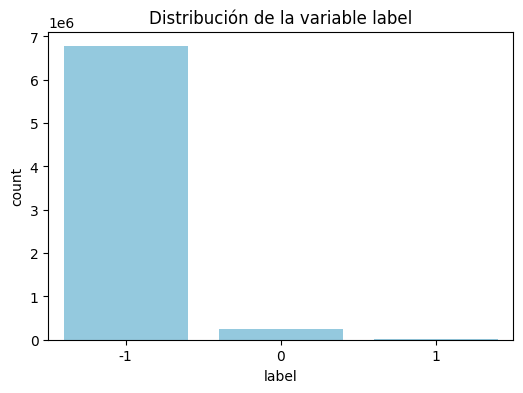

In [13]:
# Distribución de la variable label
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=dataTrain, color='skyblue')
plt.title('Distribución de la variable label')
plt.show()


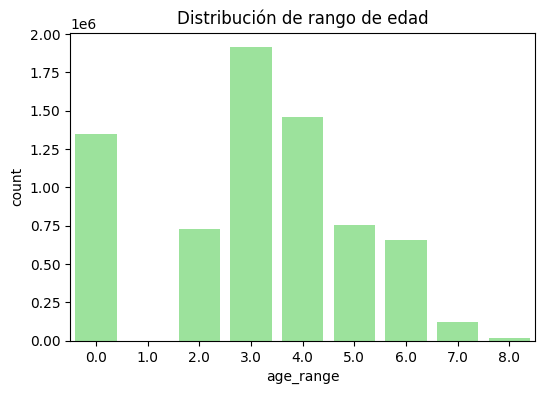

In [21]:
# Distribución de la edad
plt.figure(figsize=(6,4))
sns.countplot(x='age_range', data=dataTrain, color='lightgreen')
plt.title('Distribución de rango de edad')
plt.show()


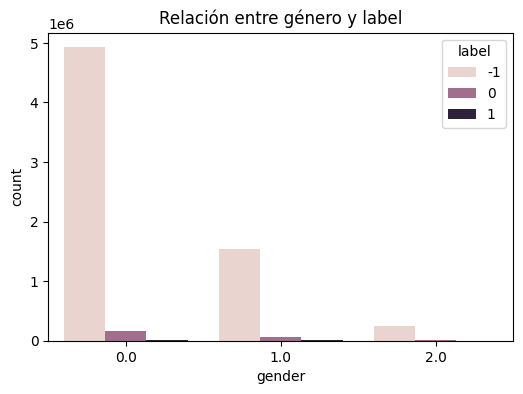

In [15]:
# Relación entre género y label
plt.figure(figsize=(6,4))
sns.countplot(x='gender', hue='label', data=dataTrain)
plt.title('Relación entre género y label')
plt.show()


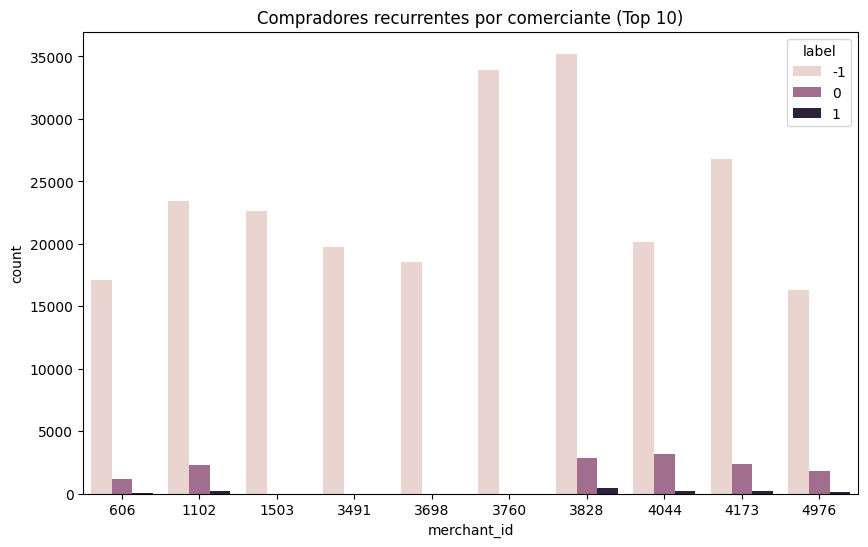

In [16]:
# Ver la cantidad de compradores recurrentes por comerciante
plt.figure(figsize=(10,6))
top_merchants = dataTrain['merchant_id'].value_counts().nlargest(10).index
sns.countplot(x='merchant_id', hue='label', data=dataTrain[dataTrain['merchant_id'].isin(top_merchants)])
plt.title('Compradores recurrentes por comerciante (Top 10)')
plt.show()


C:\Users\lijv1.LINDA_HP\AppData\Local\Temp\ipykernel_12744\334416616.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_sample['activity_count'] = user_sample['activity_log'].apply(lambda x: len(str(x).split('#')))


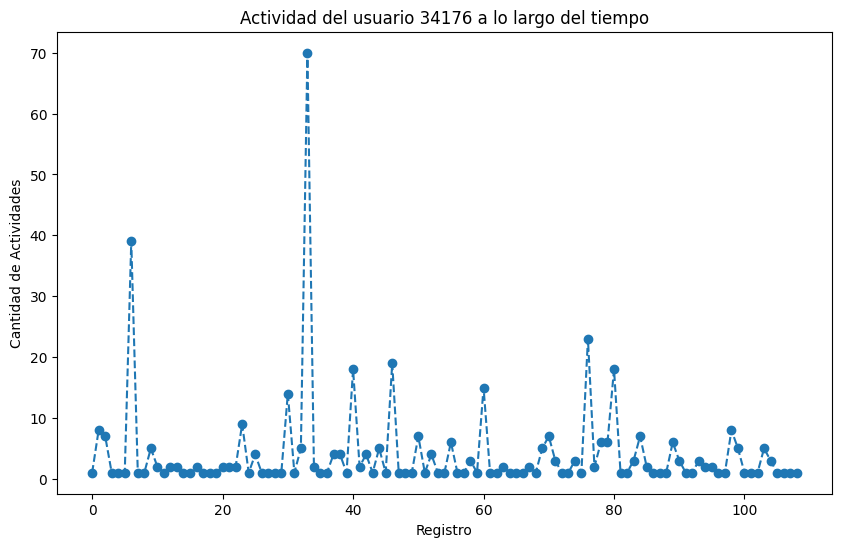

In [20]:
# Visualizar las actividades de un usuario específico
user_sample = dataTrain[dataTrain['user_id'] == 34176]  # Reemplaza con un user_id de interés

# Calcular la cantidad de actividades para cada registro
user_sample['activity_count'] = user_sample['activity_log'].apply(lambda x: len(str(x).split('#')))

# Muestra las actividades de este usuario a lo largo del tiempo (si hay timestamps en activity_log)
plt.figure(figsize=(10,6))
plt.plot(user_sample.index, user_sample['activity_count'], marker='o', linestyle='--')
plt.title(f'Actividad del usuario {34176} a lo largo del tiempo')
plt.xlabel('Registro')
plt.ylabel('Cantidad de Actividades')
plt.show()
